<a href="https://colab.research.google.com/github/dbetm/my-ai-history/blob/master/exploration/segment-anything-meta/playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Use GPU

Runtime > Change runtime type > Hardware accelerator > GPU

In [1]:
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

## Install SAMA

 GitHub repo: https://github.com/facebookresearch/segment-anything

In [2]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-azb1bsqf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-azb1bsqf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=e44b9df569dcab22686045271f7b6b2124111f38bc41a3dc071d4c732224c143
  Stored in directory: /tmp/pip-ephem-wheel-cache-u15iw0rp/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


## Download weights

Model types:
- vit_h (larger) - 2.4 GB
- vit_l - 1.2 GB
- vit_b (smaller) - 358 MB

They are downloaded as pth files, which are PyTorch state dictionaries (contain the state of a model - weights, biases and another params).

In [3]:
from http import HTTPStatus

import requests

MODEL_NAME = "vit_h"
VIT_H_MODEL_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
VIT_H_MODEL_LOCAL_PATH = "model_vit_h.pth"

response = requests.get(url=VIT_H_MODEL_URL)

if response.status_code == HTTPStatus.OK:
    with open(VIT_H_MODEL_LOCAL_PATH, "wb") as f:
        f.write(response.content)
else:
    print(response.status_code)

## Generating masks

In [4]:
from segment_anything import (
    SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
)

sam = sam_model_registry[MODEL_NAME](checkpoint=VIT_H_MODEL_LOCAL_PATH).to(
    device=DEVICE
)


In [5]:
mask_gen = SamAutomaticMaskGenerator(model=sam)

In [7]:
import numpy as np
from PIL import Image


img = Image.open("loco.jpeg") # RGB
img = np.asarray(img)

masks = mask_gen.generate(image=img)
masks[0]

## Demo app


In [ ]:
!pip install supervision

In [18]:
from io import BytesIO

import ipywidgets as widgets
import supervision as sv

mask_annotator = sv.MaskAnnotator()

In [15]:
btn_run = widgets.Button(description="Generate masks")
btn_upload = widgets.FileUpload()

In [19]:
btn_upload = widgets.FileUpload()

def on_click(change):
    img = Image.open(BytesIO(btn_upload.data[-1]))
    img = np.asarray(img)
    bgr_img = img[:, :, ::-1]

    masks = mask_gen.generate(image=img)

    detections = sv.Detections.from_sam(sam_result=masks)

    annotated_image = mask_annotator.annotate(
        scene=bgr_img.copy(), detections=detections
    )

    sv.plot_images_grid(
        images=[bgr_img, annotated_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )


btn_run.on_click(on_click)

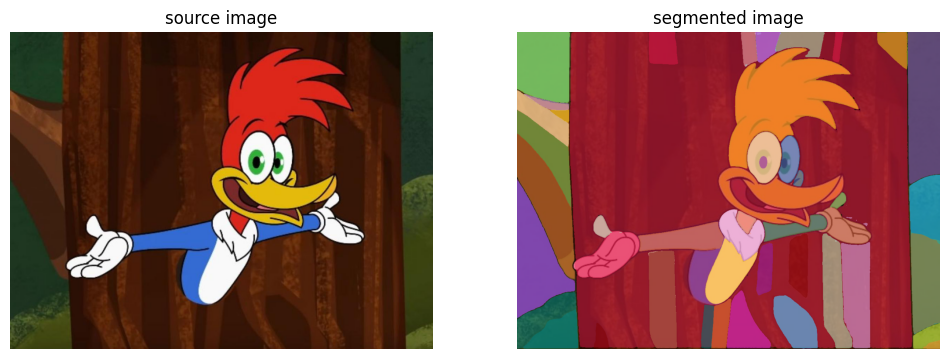

In [20]:
widgets.VBox(
    [
        widgets.Label("Select your image!"), 
        btn_upload,
        btn_run,
    ]
)